In [1]:
%matplotlib inline

In [2]:
import os
os.chdir("../")

from markowitz.structs import DBCache
from markowitz.layout_parser import from_file
from markowitz import consumme_window
from matplotlib.pyplot import show

def main(db, layout_file):
    layout = from_file(layout_file)

    for window in layout:
        consumme_window(window, db)
    
    show()


db = DBCache("cac40.db")

# Représentation graphique de la Théorie moderne du portefeuille

## Léo Duret & Adrien Chaillout-Morlot

## Introduction

La Théorie Moderne du Portefeuille De Markowitz  est un modèle incontournable des théories de gestion des actifs.
Elle a été proposé en 1952 par l'économiste américain Harry Markowitz, le rendant lauréat d'un prix Nobel en Sciences Economiques. On connait bien les représentations graphiques classiques des portefeuilles à deux titres qui ne font pas parler les nuances des bases de données. Ainsi dans ce rapport nous essayerons d'apporter de nouveaux éléments sur ces représentations graphiques en construisant une application et des outils permettant cette visualisation. 



## 1. Modèle

Afin de comprendre l'origine les graphiques qui vont suivre nous proposons au lecteur un rappel sur la théorie moderne  du portefeuille.

### 1.1 Hypothèses 

#### 1.1.1 Rationalité des agents

La théorie moderne du portefeuille ne propose pas de portefeuille optimal, seulement un ensemble paires risque/rendement optimaux (la frontière efficiente). L'hypotèse de rationnalité implique qu'il existe un seul portefeuille qui maximise l'utilité de l'agent, celui avec le meilleur rendement au risque le plus faible (selon l'aversion au risque de l'agent).

#### 1.1.2 Aversion aux risques

Dans le modèle de markowitz le rendement se paie au prix du risque. En effet, l'investisseur n'augmentera son risque si et seulement si son ésperance de gains augmente.



### 1.2 Rendement-Risque
Les hypotèses en têtes nous pouvons ainsi definir les variables de mesure du rendement et du risque dans le modèle de markowitz.
Tout d'abord on procède à une analyse individuelle des titres en étudiant les variations historiques. Dans notre cas nous avons étudié les titres du CAC40 entre le 20/10/2015 et les 19/10/2015.

Pour un titre possedant $t$ valeurs on calcule la variation entre les valeurs de fermeture du marché:

\begin{align}
    V_t = \ln(X_t) - \ln(X_{t-1})
\end{align}

ainsi que le rendement, soit l'ésperance de variation:

\begin{align}
    \overline{R_{titre}} = E(R_{titre} )=\frac{1}{N}\sum\nolimits_{i=0}^{N}R_i   
\end{align}

Enfin afin de determiner le risque d'un actif calcule l'écart type des variations, que l'on peut interpreter comme étant la volatilité du titre durant la période étudiée.

\begin{align}
    \sigma_{titre}=\sqrt{\frac{\mathrm{\sum\nolimits_{i=0}^{N}(R_i-\overline{R_{titre}})^2} }{\mathrm{(N-1)} }   }
\end{align}

### 1.3 Portefeuille
On considère un portefeuille comme étant une collection d'actifs, ainsi par croisements des données on peut observer les matrices de covariance et par extension de corrélation.

On rappelle le calcul de la covariance:

\begin{align}
    Cov(R_A,R_B)= E(R_A \cdot R_B ) - E(R_A)\cdot E(R_B)
\end{align}

Et du coefficient de corrélation $\varphi$:

\begin{align} 
    \varphi_{AB}= \frac{\mathrm{Cov( R_A \cdot R_B )} }{\mathrm{  \sigma_A \sigma_B } }
\end{align}


Exemple de matrice de covariance pour 3 titres

\begin{pmatrix}
    Var(R_A)&Cov(R_A, R_B)&Cov(R_A, R_C)\\
    Cov(R_B, R_A)&Var(R_B)&Cov(R_B, R_C)\\
    Cov(R_C, R_A)&Cov(R_C, R_B)&Var(R_C)
\end{pmatrix} 

Idem pour la matrice de corrélation

\begin{pmatrix}
    1&\varphi_{AB}&\varphi_{AC}\\
    \varphi_{BA}&1&\varphi_{BC}\\
    \varphi_{CA}&\varphi_{CB}&1
\end{pmatrix} 

In [3]:
# Nous avons ajouté la possibilité d'afficher ces variables dans un récapitulatif du portefeuille

p = db.load("renault","peugeot","lvmh")

p.recap()


,renault,peugeot,lvmh
len,515,515,515
avg,0.00035596,0.000786689,0.000911761
stdv,0.0197384,0.0212004,0.0143329
COVAR,,,
renault,0.000389606,0.00033382,0.000152542
peugeot,0.00033382,0.000449456,0.000163033
lvmh,0.000152542,0.000163033,0.000205432
CORR,,,
renault,1,0.797731,0.539191
peugeot,0.797731,1,0.536535


### 1.4 Base de données

#### 1.4.1 Aperçu
Nous avions à notre disposition des fichiers Excel d'actifs du CAC 40.

L'interval est 20/10/2015 - 19/10/2017 pour 515 entrées par tableau, entrées ayant toutes leurs valeurs.

##### Ex: Airliquide


| ISIN         | JOUR       | OUVR     | PHAUT    | PBAS     | CLOT     | VOLUME  |
|--------------|------------|----------|----------|----------|----------|---------|
| FR0000120073 | 20/10/2015 | 100      | 100.1818 | 98.4546  | 99.0909  | 833851  |
| FR0000120073 | 21/10/2015 | 99.6364  | 100.0455 | 98.3636  | 99.6818  | 714208  |
| FR0000120073 | 22/10/2015 | 99.5     | 103.4546 | 99.1818  | 103.0455 | 1264656 |
| FR0000120073 | 23/10/2015 | 104.0454 | 105.9546 | 103.6818 | 105.3636 | 1224405 |



#### 1.4.2 Transformation

Afin de pouvoir construire un application permettant d'afficher les graphiques il était important de pouvoir recuperer les données au même endroit. Dans cette optique nous avons créé un script `docs/script/excel_to_db.py` permettant de transferer un ensemble de fichiers excel sur une base de donnée (tel que un fichier soit un tableau). On peut observer ci dessous l'instruction de création des tableaux sur une base de données [SQLite](https://sqlite.org/index.html).

![Capture de la base de donnée et la structure du tableau](img/database_screen.png)

## 2. Construction de l'application

### 2.1 Avant de commencer

#### 2.1.1 Objectifs

Afin de pouvoir automatiser la production de graphiques de la théorie moderne du portefeuille il fallait determiner un certain nombre d'objectifs à respecter, nous fournissant ainsi une direction pour la construction de l'application.

- Tout d'abord il est certain qu'il fallait faire en sorte que l'application soit facile d'utilisation. La construction de graphiques simples se doit d'être simple, et donc ne doit pas demander à l'utilisateur de connaitre les fonctionnalités obscures d'un tableur ou la complexité d'un language de programmation.

- En suite une interface modulable serait de mise car on ne peut pas se contenter de montrer qu'une vérité. Laisser libre cours à l'utilisateur de tordre la donnée dans le sens qu'il souhaite était donc un élément indispensable.

- Enfin construire un application a part entière est déjà en soit une belle aventure, cependant le format pousse une utilisation pré-maché du logiciel. Ainsi une part du projet est consacré a l'élaboration d'utilitaires pour faciliter la programme d'outils connexe à la théorie moderne du portefeuille.

#### 2.1.2 Les outils

Pour ce projet nous avons décidé d'utiliser python, un language de programmation général crée par Guido van Rossum et publié en 1991. Cependant, avec maturité du language, nous n'avions pas à construire tous les outils permettant l'affichage de graphique. Ainsi, nous avons utilisé plusieurs librairie permettant de construire les courbes ainsi que de structurer les informations pendant l'execution du programme.

Les outils utilisés sont les suivants:
- [Numpy](https://www.numpy.org/) La librairie de référence en matière de calculs mathématiques et de travail avec les listes. les autres librairies dépendent de celle-ci.
- [Pandas](http://pandas.pydata.org/) une librairie permettant l'utilisation de DataFrames (sorte de tableau) semblables à celles en R.
- [Matplotlib](https://matplotlib.org/) la librairie pour l'affichage des graphiques.


### 2.2 L'implémentation

#### 2.2.1 Les produits selon markowitz et accès à la base de donnée

##### 2.2.1.1 Titres
Rappelons nous des méthodes de calculs vu précédements pour imaginer un concept de "titre financier de markowitz". Nous avons décris un calcul se déroulant à partir des valeurs passés du titres ainsi la première chose à faire est acceder la base de donnée pour récuperer cet historique. Heureusement pour nous la librairie pandas nous facilite la tache en nous permettant de créer une DataFrame directement depuis une requete de la base de donnée.

In [4]:
# Nous travaillerons sur les valeurs de clotures ainsi la requete se matérialise de cette manière:
import pandas as pd
import sqlite3 as sql

conn = sql.connect("cac40.db")
df = pd.read_sql("SELECT clot FROM AXA", conn)

print(df.head(n=5))  # 5 premières valeurs

     clot
0  22.915
1  23.095
2  23.820
3  24.050
4  24.155


In [5]:
# On calcule la variation:

print(df["clot"].pct_change().head(n=5))  # 5 premières valeurs

0         NaN
1    0.007855
2    0.031392
3    0.009656
4    0.004366
Name: clot, dtype: float64


Dans notre cas les instances de clotures ayant toutes des valeurs cohérentes, il n'est pas necessaire de nettoyer le tableau des valeurs manquantes ou inéxactes. Pour d'optimiser les opérations de lecture de la structure "Titre" nous stockerons indépendamment les valeurs constante fréquemments utilisé calculés à partir du tableau des variation, soit l'éspérance et l'équart type. Nous gardons tout de meme le tableau des variations pour le calcul de la corrélation des portefeuilles.

##### 2.2.1.2 Portefeuille

Comme définit précédemment, un portefeuille est un ensemble de titres il est donc important que nous utilisions les équations générales et que nous puissions passer autant de titres que nous voulons tout en gardant la possibilité de calculer leur ésperance. Python nous facilite la tache avec une notation permettant de passer autant d'arguments à une fonction/méthode `def __init__(self, *args):`. Il ne reste plus qu'à implementer les fonctions de calculs de l'éspérance et de la variance (ci-dessous).

###### L'ésperance
Soit $\{R_1, ..., R_n\}$ titre dans le portefeuille

\begin{align}
    E(R_p) = \sum_{i=0}^{n}\alpha_i \cdot E(R_i)
\end{align}



In [ ]:
# Esperance
def avg(self, dot: m_types.FLOAT_COLLECTION) -> m_types.M_FLOAT:  # dot: liste de nombre à virgule
    mus = [el.avg for el in self.assets.values()]  # Liste des éspérances des titres
    assert(len(dot) == len(mus))  # Assure le nombre de dotations rapporté à la taille du portefeuille
    
    # Somme du produit des éspérances (mus) et des dotations (dot)
    result: float = 0
    for i in range(len(dot)):  
        result += dot[i] * mus[i]
    
    return m_types.M_FLOAT(result)

###### L'écart type

\begin{align}
    Var(R_P) = (\sum_{i=0}^{n}\alpha_i \cdot \sigma_i)^2
\end{align}

C'est une forme quadratique d'ordre N donc il existe une matrice symétrique $ N \cdot N $ associée 
Pour 3 titres on trouve

\begin{pmatrix}
     \alpha^2_{1}& \frac{\mathrm{\alpha_1\alpha_2} }{\mathrm{2}} &\frac{\mathrm{\alpha_1\alpha_3} }{\mathrm{2}}\\
    \frac{\mathrm{\alpha_1\alpha_2} }{\mathrm{2}}&\alpha^2_2&\frac{\mathrm{\alpha_2\alpha_3} }{\mathrm{2}}\\
    \frac{\mathrm{\alpha_1\alpha_3} }{\mathrm{2}}&\frac{\mathrm{\alpha_2\alpha_3} }{\mathrm{2}}&\alpha^2_{3}
\end{pmatrix}

Ainsi

\begin{align}
    A = M_{quadratique} \cdot M_{covar}\\
\end{align}

La trace de A est la somme des variances pondérés par les $\alpha_i$, soit la variance de $R_p$

\begin{align}
    trace(A)= Var(R_P)
\end{align}

\begin{align}
    \sigma_{R_P} = \sqrt{Var(R_P)} = \sqrt{trace(A)}
\end{align}

In [ ]:
# Ecart type

def stdv(self, dot: m_types.FLOAT_COLLECTION) -> m_types.M_FLOAT:
    assert(len(dot) == len(self.assets))  # Assure le nombre de dotations rapportés à la taille du portefeuille
    
    product = m_maths.dot(m_maths.symmetric_matrix(dot), self.covar_matrix)  # Produit matriciel de la matrice symmétrique et de covariance
    trace = m_maths.sqrt(m_maths.trace(product))  # Racine carré de la trace du produit matriciel
    
    return m_types.M_FLOAT(trace)

##### 2.2.1.3 L'interface de la base de donnée

Les produits ci-dessus sont construits à partir d'une base de donnée, cependant on remarque que si l'on souhaite afficher plusieurs fois le même titres avec l'application, les memes informations seront demandé plusieurs fois à la base de donnée. C'est comme si à chaque fois que vous rejoignez votre hotel on vous demandait de repasser par la reception pour prendre une chambre.

Pour remedier à ce problème et optimiser l'application nous avons mis en place un schema très simple mais éfficace. Tout d'abord on va distinguer deux elements dans la base de donnée. Ces éléments vont se comporter comme un gardien et un réceptioniste. En effet si le gardien vous reconnait il vous laisse acceder à votre chambre sinon c'est la case reception. Traduisons cela et vous avez une instance d'object servant de gardien dont le travaille est de determiner si le titre à déjà été créé sinon demander à l'autre objet (la récéption) de s'en charger et de vous le remettre.

De cette manière nous sommes assuré que chaque titre et portfeuille est chargé au maximum une fois. Ceci conclut notre module structure de donnée dont l'interface est basique: les services ayant besoin d'un titre n'ont qu'a effectuer une demande à l'objet servant de gardien.

#### 2.2.2 L'architecture

Concernant l'architecture du programme elle est plutot simple:
- D'abord la déconstruction des fichiers de layout en classes connexes contenant les informations des differents graphiques
- En suite lecture des objects de graphique, chargement de la base de donnée et des objets graphiques (prochaine section)
- Enfin assemblage des titres et des objets de graphiques
- Affichage des graphiques

![Architecture du programme](img/arch.png)

### 2.3 Les graphiques

Pour afficher les graphiques nous avons créé une syntaxe nous permettant de lire les graphiques directemment depuis un fichier contenant seulement les informations sur les titres et le type de graphique à utiliser. Ces type de graphique sont en  fait des référence à des fichiers contenant les objects du meme noms. Ainsi les graphiques sont généré dynamiquement lorsque leur nom est reconnu.

La syntaxe des fichiers est plutôt simple
- Pour les commentaires: `! ...`
- Nouvelle fenetre: `& nom_fenetre (configuration...) { matrice... }`
- Pour la configuration: `(nom=valeur,...)`
- Pour la matrice:
    - ligne: `[...]`
    - separateur de colonne: `|`
- Les objects: `nom_objet(titre)` ou `nom_objet(titre/titre/...)` pour plusieurs titres

Le chargements de objects est effectué dynamiquement celon le nom de l'objet appelé dans le fichier. Enfin la base de donnée charge un titre lorsque que l'analyse du fichier ne trouve qu'un `titre`, sinon un portefeuille contenant les titres est généré dans le cas où plusieurs titres sont reconnus (`titre/titre`)

#### 2.3.1 Analyse des titres

##### 2.3.1.1 Distribution normale

Afin d'analyser et comparer les titres nous avons fournit un moyen de représenter graphiquement l'ésperance et l'écart type de ces derniers. En effet les titres étant composé d'une large quantité de valeurs, on peut estimer que la loi de leur variation peut s'approximer par une loi normale. Ainsi, dans un premier temps nous avons fournit un objet permettant de calculer les points d'une loi normale de paramètre $N(\mu, \sigma)$

En créant un ensemble de points entre $-10$ et $10$ leur applicant cette fonction, nous avons créé un emble de points $x$ et $y$ que nous affichons sur un graphique.

In [ ]:
# NormalGraph.const1 = np.sqrt(2*np.pi)
# args[0] = mu
# args[1] = sigma

def densite(point, *args):
    t1 = 1/(args[1]*NormalGraph.const1)
    x = (point-args[0])/args[1]
    t2 = np.exp(-0.5*x*x)
    return t1*t2

In [6]:
with open("docs/layouts/normale.ly") as ly:
    print(ly.read())

! docs/layouts/layout3.ly

& Normale (scale=100) {
	[ NormalGraph(axa) | NormalGraph(lvmh) ]
    [ NormalGraph(peugeot) ]
}



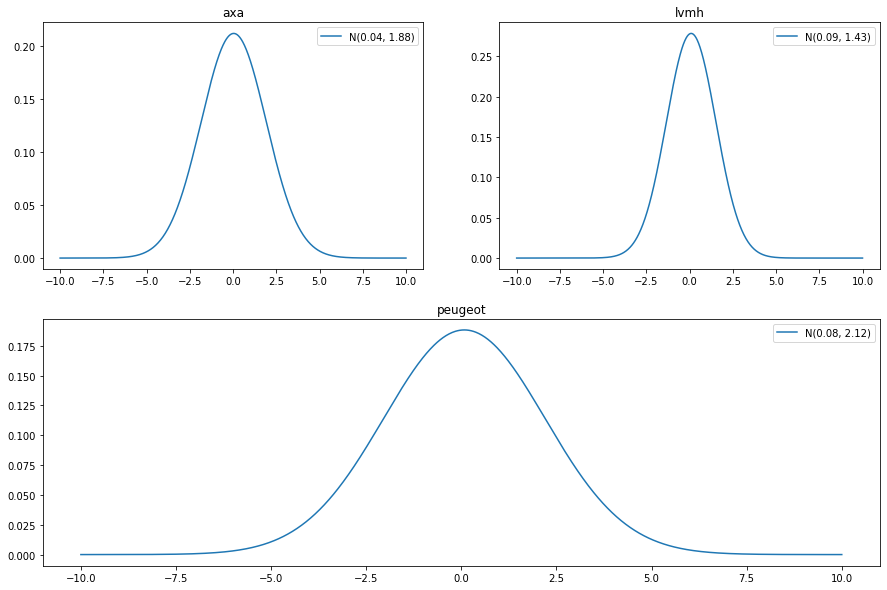

In [7]:
main(db, "docs/layouts/normale.ly")

##### 2.3.1.1 Estimation de la densité par la méthode des noyaux

Cependant la distribution normale n'est pas un bon indicateur pour exprimer les series à evennements improbables. En effet les "pattes" de la loi normale nous montrent que les hautes variations ont très peut de chance d'arriver. Cependant sur les marchés financiers ces evennements ne sont pas a sous-estimer. Pour demontrer cette réalité il faut trouver un moyen d'afficher la "vraie" taille des pattes de la loi normale. Pour ce faire nous avons implémenté un moyen d'observer une approximation de la densité des la série en utilisant la méthode de l'éstimation de la densité par noyau, Kernel Density Estimation en anglais, d'ou le nom KDE pour les graphiques.

Pour l'estimation de la densité nous avons choisit un noyau normale car nous cherchions à estimer la taille des pattes. Et un parametre $h$ de 1.06 selon les recommendations, le resultat paraissant satisfaisant. Le principe de l'estimation de densité par noyau est de créer un ensemble de loi normale et d'en faire la somme. Ainsi on observe une agrégation plus importante autour de l'esperance de la série mais les valeurs plus extremes sont aussi prisent en compte.

In [ ]:
# Kde.const1 = np.sqrt(2*np.pi)

def _kernel(k):
    """ Kernel of the KDE """
    return (1/Kde.const1)*np.exp(-0.5*k*k)

def densite(point, df, stdv):
    """ estimation function """
    n = len(df-1)  # index 0 is NaN
    h = 1.06 * (stdv)/np.power(n, 0.2)
    pre = 1.0/(n*h)
    results = [
        Kde._kernel((point-xi)/h)
        for xi in df
        if not np.isnan(xi)
    ]
    return np.sum(results) * pre

In [10]:
with open("docs/layouts/kde.ly") as ly:
    print(ly.read())

! docs/layouts/layout3.ly

& Kde (scale=100) {
	[ NormalGraph(axa) Kde(axa) ]
}



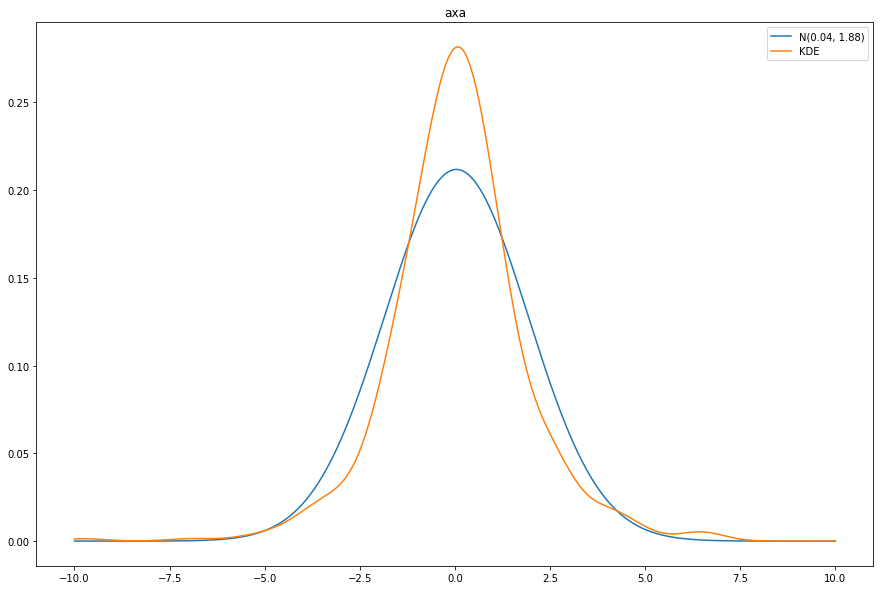

In [11]:
main(db, "docs/layouts/kde.ly")

#### 2.3.2 Efficacité des portefeuilles

##### 2.3.2.1 Génération du plan à deux titre

Afin d'afficher un graphique nous devons spécifier un ensemble de dotations à passer pour le calcul de l'éspérance et de la variance du portefeuille.
Dans le cas ou nous avons seulement 2 dotations il suffit de generer $x$ et donner $y = 1-x$ ainsi à partir d'une liste de $x$ nous donnons une liste de $y$, nous pouvons passer ces paires directement dans la fonction de calcul. Le plan à deux titres peut s'interpreter de cette manière: _Il n'existe pas de meilleur paires rendement/risque que celles sur la courbe_.

In [12]:
with open("docs/layouts/layout1.ly") as ly:
    print(ly.read())

! docs/layouts/layout1.ly

& 2PF (scale=100) {
	[ EfficientFrontier(axa/lvmh) ]
}



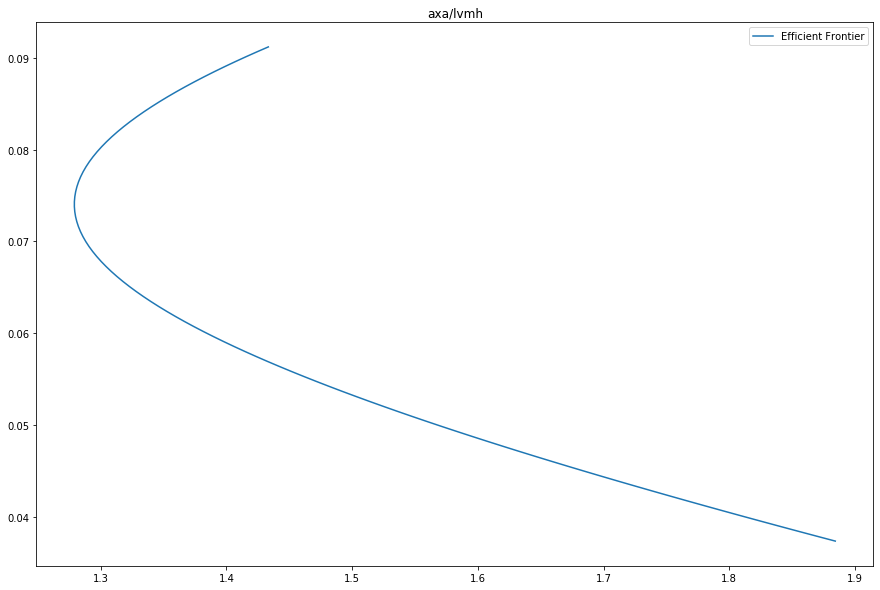

In [13]:
main(db, "docs/layouts/layout1.ly")

##### 2.3.2.2 Génération du plan barycentrique (pour 3 titres)
Pour trois titres nous devons trouver une manière efficace de générer un triplet de points dont la somme équivaut à 1. Une manière de faire cela est de calculer des points sur le plan barycentrique. Heureusement, l'industrie du graphisme numérique à developpé ces algorithmes afin de pouvoir remplir des triangles et afficher des modèles coloré. L'algo rythme utilisé est plutot simple:

On fixe un point (en l'occurence z) auquel on retire à plusieur étapes un nombre 's' ( $ 1 / totaletapes$ ) puis on calcule tous les points x, y qui correspondent à
$x + y = nbetapes*s$


![Image de la génération de l'espace](img/rasterizer_screen.png)

In [14]:
with open("docs/layouts/layout2.ly") as ly:
    print(ly.read())

! docs/layouts/layout2.ly

& 3PF (scale=100) {
	[ EfficientFrontier(axa/lvmh/engie) ]
}



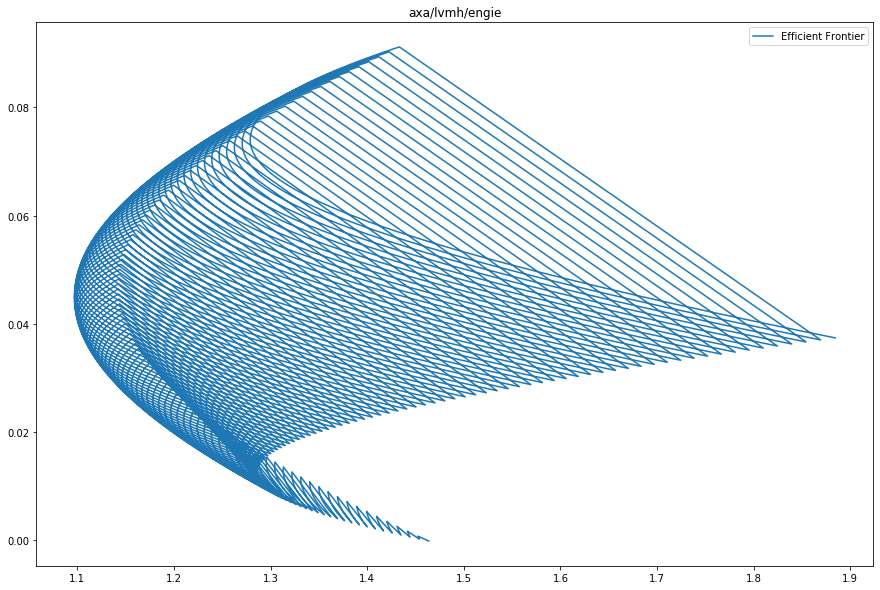

In [15]:
main(db, "docs/layouts/layout2.ly")

##### 2.3.2.3 Génération du plan à N titre

Pour afficher la frontière efficiente à N titres nous avons du utiliser des méthodes plus approximatives. En effet l'algorithme au dessus est déjà couteux pour un grand nombre de points généré. Ansi pour N titres nous faisons appel à la librairie *numpy* qui permet de calculer des points d'une distribution de *Dirichlet*, et cela de manière aléatoire. Ainsi nous avons un ensemble de points respectant $\sum_{i=0}^{n}\alpha_i = 1$

In [16]:
with open("docs/layouts/layout3.ly") as ly:
    print(ly.read())

! docs/layouts/layout3.ly

& NPF (scale=100) {
	[ EfficientFrontier(axa/lvmh/engie/peugeot/renault) ]
}



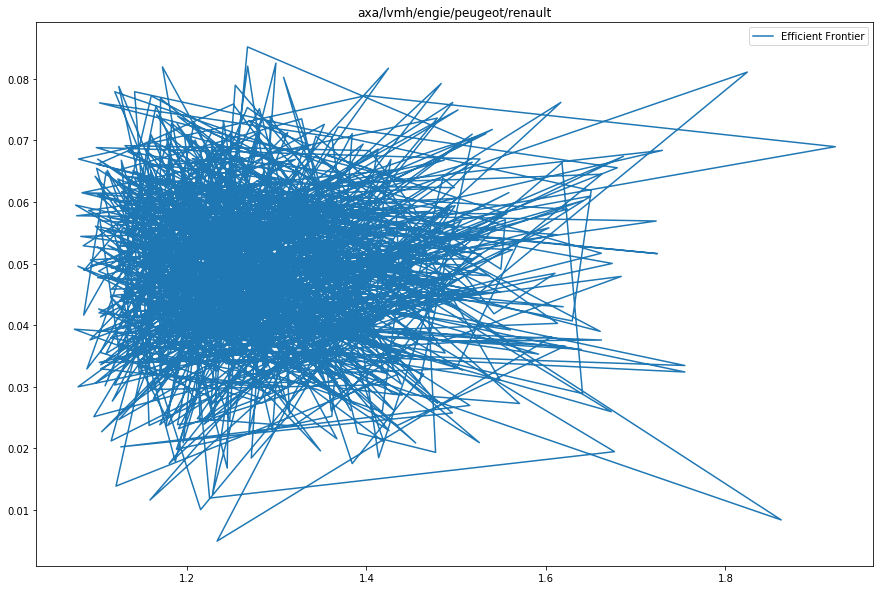

In [27]:
main(db, "docs/layouts/layout3.ly")

## Conclusion

Ainsi à travers ces differents graphiques nous avons pu observer les différents manière d'observe la théorie moderne du portefeuille de markowitz, que se soit du point de vu des titres, ou bien encore de la fontière efficiente à toutes les dimensions. Par la théorie moderne du portefeuille markowitz nous montre que la diversification des actifs, en baissant le rendement, réduit considérablement le risque des agents.

### Critiques

On observe deux critiques majeurs de la théorie moderne du portefeuille:

- La première critique vient de Benoit Mandelbrot qui estime cette théorie trop déconnecté des marchés financiers. En effet la loi de gauss sous évalue la probabilité d'évenements improbables (notamment les krachs boursiers). Nous avons observé un example en comparant avec l'estimation par noyau.

- La deuxième critique, plus intuitive, sont que les suppositions néo-classiques sont irréalistes, les individus ne sont pas rationnels et les variations passé ne se répètent pas dans le futur.

### Ouverture

Afin de répondre à ces critiques et mieux anticiper les évenements improbables on peut utiliser la loi de pareto ou les lois de puissance qui on moins tendance à les sous evaluer.



Le code est disponibles sur : [github.com/hyyking/markowitz](https://github.com/hyyking/markowitz)

La bibliographie : [bibliographie](https://github.com/hyyking/markowitz/tree/master/docs/references)